# Part 3: Truncation and TruncatedStep

In [1]:
!pip install git+https://github.com/google/learned_optimization.git

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import functools
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule
from learned_optimization.outer_trainers import common
from learned_optimization.outer_trainers import lopt_truncated_step
from learned_optimization.outer_trainers import truncated_step as truncated_step_mod

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import training
from learned_optimization import eval_training

import haiku as hk
import tqdm

## Training learned optimizers: Truncated training, and different kinds of gradient estimators.

In the previous colabs we showed some of the core abstractions this library is based on: `Task`, `Optimizer`, `LearnedOptimizer`, and `TaskFamily`. We also showed a rather minimal meta-training procedure
which trains learned optimizers to perform well with a handful of inner-training steps.

In this colab, we discuss inner-training and meta-training in more detail and discuss some of the more heavy weight abstractions designed to facilitate this.

First, we will discuss truncations, and `TruncationSchedule` which  define how long to unroll a particular sequence. Next, we will discuss the `TruncatedStep` abstraction which provide an interface for performing inner-training using some meta-learned components.
While this might seem abstract at the moment, this `TruncatedStep`
abstraction allows us to compute gradients of the meta-learned components using ES, PES, or backprop of any
iterative system and is general enough to work with learned optimizers, as well as other meta-learned systems.

## Truncated training and TruncationSchedules

When applying a learned optimizer to train some target task, one usually wants the optimizer to be performant for a very large number of steps as training a model can take hundreds to hundreds of thousands of iterations.
Ideally we would like our meta-training procedure to mirror the testing setup but given how long these unrolls (iterative application of the learned optimizer) can be this can become challenging. Truncated training is one solution to this. The core idea is to never run an entire inner-problem to completion, but instead unroll a shorter segment, and leverage information from that shorter segment to update the weights of the learned optimizer.

This is most commonly seen in the form of truncated backpropogation through time and is used to train training recurrent neural networks. More recently, truncated training has been used to train RL algorithms (e.g. A3C).

Truncated training has a number of benifits. First, it greatly reduces the amount of computation needed before updating the learned optimizer. If one has length 100 truncations for a total length of 10k iterations, one 100x more updates to the weights of the learned optimizer. For some methods, like PES, we can even do these gradient estimates in an unbiased way (technically less biased, see PES paper for a discussion on hysteresis). For others, such as gradient based meta-training, and other ES variants, this comes at the cost of bias.

In code, truncations are handed by a TruncationSchedule subclass which is a small, stateless classes which manage how long we should be computing training for. For example, here we see a constant length truncation which runs for 10 steps then reports done.

In [3]:
trunc_sched = truncation_schedule.ConstantTruncationSchedule(10)
outer_state = None
key = jax.random.PRNGKey(0)
trunc_state = trunc_sched.init(key, outer_state)
for i in range(12):
  trunc_state, is_done = trunc_sched.next_state(trunc_state, i, key,
                                                outer_state)
  print(i, is_done)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 True
11 True


In practice, we often run these sequentially.

For example, here is a loop which let's us sequentially train a model over and over again.
To do this, we must keep track of some state which progresses from inner-iteration to
inner-iteration.
In this case, this contains three values: the problem we are training's `opt_state`, the
state of the truncation, and a rng key.

In [4]:
key = jax.random.PRNGKey(0)
task = image_mlp.ImageMLP_FashionMnist8_Relu32()
opt = opt_base.Adam(3e-3)
outer_state = None


def init_state(key):
  key, key1, key2 = jax.random.split(key, 3)
  p = task.init(key1)
  opt_state = opt.init(p)

  trunc_sched = truncation_schedule.ConstantTruncationSchedule(50)
  trunc_state = trunc_sched.init(key2, outer_state)

  return opt_state, trunc_state, key


def next_trunc_and_train(train_state_and_batch):
  (opt_state, trunc_state, key), batch = train_state_and_batch
  # progress one step on the truncation state
  trunc_state, is_done = trunc_sched.next_state(trunc_state,
                                                opt_state.iteration, key,
                                                outer_state)

  # progress one step by computing a gradient and applying an update.
  p = opt.get_params(opt_state)
  key, key1 = jax.random.split(key)
  l, g = jax.value_and_grad(task.loss)(p, key1, batch)
  opt_state = opt.update(opt_state, g, loss=l)

  return (opt_state, trunc_state, key), is_done, l


def reset_trunc_and_init(train_state_and_batch):
  (opt_state, trunc_state, key), batch = train_state_and_batch

  # new inner problem
  p = task.init(key)
  opt_state = opt.init(p)

  # new truncation
  key, key1 = jax.random.split(key)
  trunc_state = trunc_sched.init(key1, outer_state)

  return (opt_state, trunc_state, key), False, jnp.nan


is_done = False
state = init_state(key)

losses = []
for i in range(200):
  batch = next(task.datasets.train)
  state, is_done, loss = jax.lax.cond(is_done, reset_trunc_and_init,
                                      next_trunc_and_train, (state, batch))
  losses.append(loss)

Now we can plot the losses. We see a sequence of decreasing losses, which get reset back to initialization every 25 steps.

Text(0, 0.5, 'loss')

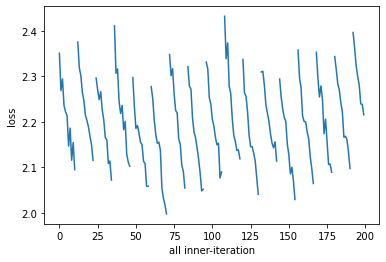

In [5]:
plt.plot(losses)
plt.xlabel("all inner-iteration")
plt.ylabel("loss")

One key reason why this abstraction is important is when thinking about training multiple models in parallel. Naively, we could train all models starting from initialization with the exact same iteration into training.
This is sometimes refered to as "lock step" training.

One alternative is to break this lock-steping, and let our models train different parts of the inner-problem at different times.
With this TruncationState abstraction we can do this by either training with variable length unrolls, or faking the initial state so models reset early.

For starters, we can see training multiple models with lock step unrolls:

In [6]:
n_tasks = 8


@jax.jit
@jax.vmap
def update(state, is_done, batch):
  state, is_done, loss = jax.lax.cond(is_done, reset_trunc_and_init,
                                      next_trunc_and_train, (state, batch))
  return state, is_done, loss


keys = jax.random.split(key, n_tasks)
states = jax.vmap(init_state)(keys)

losses = []
is_done = jnp.zeros([n_tasks])
for i in range(200):
  vec_batch = training.vec_get_batch(task, n_tasks, split="train")
  states, is_done, l = update(states, is_done, vec_batch)
  losses.append(l)

Text(0, 0.5, 'loss')

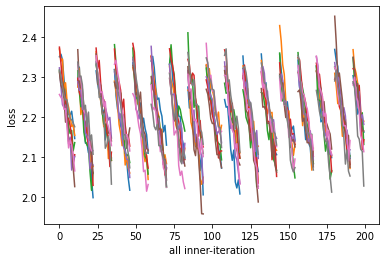

In [7]:
losses = np.asarray(losses)
for i in range(n_tasks):
  plt.plot(losses[:, i])

plt.xlabel("all inner-iteration")
plt.ylabel("loss")

And then, we can compare this to what the curves look like if we break the lockstep by simply faking the initial iteration.

In [8]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, n_tasks)
states = jax.vmap(init_state)(keys)
opt_state, trunc_state, keys = states
import dataclasses

opt_state = opt_state.replace(
    iteration=jax.random.randint(key, [n_tasks], 0, 50))
states = (opt_state, trunc_state, keys)

losses = []
is_done = jnp.zeros([n_tasks])
for i in range(200):
  vec_batch = training.vec_get_batch(task, n_tasks, split="train")
  states, is_done, l = update(states, is_done, vec_batch)
  losses.append(l)

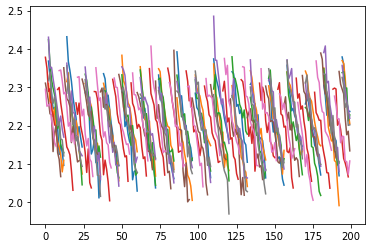

In [9]:
losses = np.asarray(losses)
for i in range(n_tasks):
  plt.plot(losses[:, i])

With this version, all the tasks start lockstep-ed initially, but then reset early so as to ensure the training trajectories are not running in lock step.

## TruncatedStep: An interface for unrolled computation graphs

The TruncatedStep abstraction defines an interface which can be used to inner-train a task with some meta-learned pieces.

This abstraction is entirely independent of learned optimizers and can (hopefully) be used for just about any meta-learning system.

The interface exposes the following:
  * `outer_init`: Initialize outer parameters (weights of learned optimizer).
  * `init_step_state`: Which initializes the state of the inner problem.
  * `unroll_step`: Which trains the inner-problem state a single step using the learned algorithm.
  * `meta_loss_batch`: Computes a meta-loss from a given inner-problem state.

Inner-training, and computing meta-losses often require data. To this end, `TruncatedStep` also provide a `get_batch` and `get_outer_batch` for getting data for inner-training, and computing meta-losses respectively.

When we use this abstraction, we iterativly apply unroll_step. As such, we must ensure that this function occasionally resets as we saw in the previous section with truncation schedules.

As a demonstration of this, let's define a simple `TruncatedStep` for a learned optimizer. For many cases, this is unnecessary as `VectorizedLOptTruncatedStep` should be used as it supports task family, truncation schedule and a number of different ways to calculate meta-loss.

In [10]:
class SimpleLOptTruncStep(truncated_step_mod.TruncatedStep):

  def __init__(self, lopt, task, unroll_length=5):
    self.lopt = lopt
    self.task = task
    self.unroll_length = unroll_length

  def outer_init(self, key):
    return self.lopt.init(key)

  def init_step_state(self, theta, outer_state, key):
    params = self.task.init(key)
    return self.lopt.opt_fn(theta).init(params)

  @functools.partial(jax.jit, static_argnums=(0,))
  def unroll_step(self, theta, unroll_state, key, data, outer_state):
    opt = self.lopt.opt_fn(theta)

    def train(unroll_state):
      params = opt.get_params(unroll_state)
      loss, grad = jax.value_and_grad(task.loss)(params, key, data)
      unroll_state = opt.update(unroll_state, grad, loss=loss)
      out = truncated_step_mod.TruncatedUnrollOut(
          loss=loss,
          is_done=False,
          task_param=None,
          iteration=unroll_state.iteration,
          mask=True)
      return unroll_state, out

    def reset(unroll_state):
      params = self.task.init(key)  # Modify this
      unroll_state = self.lopt.opt_fn(theta).init(params)
      out = truncated_step_mod.TruncatedUnrollOut(
          loss=0.0,
          is_done=True,
          task_param=None,
          iteration=unroll_state.iteration,
          mask=False)
      return unroll_state, out

    return jax.lax.cond(unroll_state.iteration < self.unroll_length, train,
                        reset, unroll_state)

  def meta_loss_batch(self, theta, unroll_state, key, data, outer_state):
    params = self.lopt.opt_fn(theta).get_params(unroll_state)
    return task.loss(params, key, data)

  def get_batch(self, steps=None):
    if steps is None:
      return next(task.train)
    else:
      return training.vec_get_batch(task, steps, split="train")

  def get_outer_batch(self, steps=None):
    if steps is None:
      return next(task.train)
    else:
      return training.vec_get_batch(task, steps, split="train")

We can now use our truncated step function in a simple loop to run 10 steps of inner-training. Because we are resetting every 5 steps, we see the loss also resets. When we reset, we report of loss as 0.0, but also have a mask=False for this iteration.

In [11]:
lopt = lopt_base.LearnableSGDM()
task = quadratics.QuadraticTask()
truncated_step = SimpleLOptTruncStep(lopt, task, unroll_length=5)

key = jax.random.PRNGKey(0)
theta = truncated_step.outer_init(key)

unroll_state = truncated_step.init_step_state(theta, None, key)
print("Iteration=", unroll_state.iteration)

for i in range(10):
  batch = jax.tree_util.tree_map(lambda x: x[0], truncated_step.get_batch(1))
  unroll_state, out = truncated_step.unroll_step(theta, unroll_state, key,
                                                 batch, None)
  print("Iteration=", unroll_state.iteration, "Loss=", out.loss, "Mask=",
        out.mask)

Iteration= 0
Iteration= 1 Loss= 2.658556 Mask= True
Iteration= 2 Loss= 2.5532773 Mask= True
Iteration= 3 Loss= 2.361111 Mask= True
Iteration= 4 Loss= 2.1044798 Mask= True
Iteration= 5 Loss= 1.8072809 Mask= True
Iteration= 0 Loss= 0.0 Mask= False
Iteration= 1 Loss= 2.658556 Mask= True
Iteration= 2 Loss= 2.5532773 Mask= True
Iteration= 3 Loss= 2.361111 Mask= True
Iteration= 4 Loss= 2.1044798 Mask= True


## VecTruncatedStep

Now for performance reasons, we often want to inner-train batches. `VecTruncatedStep` both provides an interface for vectorized steps, as well as a wrapper function to convert non-vectorized to vectorized.

In [12]:
truncated_step = truncated_step_mod.VectorizedTruncatedStep(truncated_step, 3)

key = jax.random.PRNGKey(0)
theta = truncated_step.outer_init(key)

unroll_state = truncated_step.init_step_state(theta, None, key)
print("Iteration=", unroll_state.iteration)

for i in range(10):
  batch = jax.tree_util.tree_map(lambda x: x[0], truncated_step.get_batch(1))
  unroll_state, out = truncated_step.unroll_step(theta, unroll_state, key,
                                                 batch, None)
  print("Iteration=", unroll_state.iteration, "Loss=", out.loss, "Mask=",
        out.mask)

Iteration= [0 0 0]
Iteration= [1 1 1] Loss= [8.163749  7.267569  6.8465357] Mask= [ True  True  True]
Iteration= [2 2 2] Loss= [7.8404646 6.9797735 6.5754128] Mask= [ True  True  True]
Iteration= [3 3 3] Loss= [7.25037   6.4544573 6.080529 ] Mask= [ True  True  True]
Iteration= [4 4 4] Loss= [6.4623203 5.752917  5.419631 ] Mask= [ True  True  True]
Iteration= [5 5 5] Loss= [5.549699  4.9404783 4.65426  ] Mask= [ True  True  True]
Iteration= [0 0 0] Loss= [0. 0. 0.] Mask= [False False False]
Iteration= [1 1 1] Loss= [8.163749  7.267569  6.8465357] Mask= [ True  True  True]
Iteration= [2 2 2] Loss= [7.8404646 6.9797735 6.5754128] Mask= [ True  True  True]
Iteration= [3 3 3] Loss= [7.25037   6.4544573 6.080529 ] Mask= [ True  True  True]
Iteration= [4 4 4] Loss= [6.4623203 5.752917  5.419631 ] Mask= [ True  True  True]


## VectorizedLOptTruncatedStep
In the above examples, we created a simple `TruncatedStep` for a learned optimizer and task. This is great, but in reality we want to use more of the machinery we have been developing through these notebooks -- namely, `TaskFamily` and `TruncationSchedule`. To this end, we also provide a `VectorizedLOptTruncatedStep` which takes in a `TaskFamily`, `LearnedOptimizer`, and `TruncationSchedule` and constructs the appropriate  `VectorizedTruncatedStep`.

In the below example, we will construct one fo these `TruncatedStep` on a quadratic task family, with randomized starting iteration.

In [13]:
task_family = quadratics.FixedDimQuadraticFamilyData(10)
lopt = lopt_base.LearnableSGDM()
trunc_sched = truncation_schedule.ConstantTruncationSchedule(5)
truncated_step = lopt_truncated_step.VectorizedLOptTruncatedStep(
    task_family,
    lopt,
    trunc_sched,
    num_tasks=3,
    random_initial_iteration_offset=5)

key = jax.random.PRNGKey(1)
theta = truncated_step.outer_init(key)

unroll_state = truncated_step.init_step_state(theta, None, key)
print("Iteration=", unroll_state.inner_step)

for i in range(10):
  batch = jax.tree_util.tree_map(lambda x: x[0], truncated_step.get_batch(1))
  unroll_state, out = truncated_step.unroll_step(theta, unroll_state, key,
                                                 batch, None)
  print("Iteration=", unroll_state.inner_step, "Loss=", out.loss, "Mask=",
        out.mask)

Iteration= [2 4 4]
Iteration= [3 5 5] Loss= [30.317793 32.50056  10.791804] Mask= [ True  True  True]
Iteration= [4 0 0] Loss= [28.276335  0.        0.      ] Mask= [ True False False]
Iteration= [5 1 1] Loss= [25.218487 24.83813  36.847755] Mask= [ True  True  True]
Iteration= [0 2 2] Loss= [ 0.       25.100714 33.250145] Mask= [False  True  True]
Iteration= [1 3 3] Loss= [10.66427  22.762098 31.916872] Mask= [ True  True  True]
Iteration= [2 4 4] Loss= [10.144799 20.350817 28.981028] Mask= [ True  True  True]
Iteration= [3 5 5] Loss= [ 8.875515 17.26621  23.050066] Mask= [ True  True  True]
Iteration= [4 0 0] Loss= [8.438987 0.       0.      ] Mask= [ True False False]
Iteration= [5 1 1] Loss= [ 5.835725 25.567972 35.97472 ] Mask= [ True  True  True]
Iteration= [0 2 2] Loss= [ 0.       23.460606 33.696133] Mask= [False  True  True]
